### **BIBLIOTECAS**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import nltk
import re

from nltk.stem import RSLPStemmer
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

### **PRÉ-PROCESSAMENTO**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
imdb_data = pd.read_csv('/content/drive/MyDrive/Pos_PucMinas_2021/TCC/Dados/imdb-reviews-pt-br.csv').sample(20000, random_state=42)

In [ ]:
print(imdb_data.shape)
imdb_data.head(10)

(20000, 4)


,id,text_en,text_pt,sentiment
12532,12534,This was unusual: a modern-day film which was ...,Isso era incomum: um filme moderno que era ult...,pos
35445,35447,Some of my old friends suggested me to watch t...,Alguns dos meus velhos amigos sugeriram que eu...,neg
20279,20281,What a pleasure. This is really a parody. Only...,Que prazer. Isto é realmente uma paródia. Some...,pos
2969,2971,There are about ten minutes about half way thr...,"Há cerca de dez minutos a meio da Strangeland,...",neg
45161,45163,"Othello, the classic Shakespearen story of lov...","Otelo, a clássica história de Shakespearen sob...",pos
42648,42650,"Bravo to Czechs, their once-powerful movie ind...","Bravo para os tchecos, sua outrora poderosa in...",pos
17897,17899,"So its not an award winner, so what? Have you ...","Então não é um vencedor do prêmio, e daí? Você...",pos
41126,41128,Guy Kibbee gives the viewer a lot of laughs. L...,Guy Kibbee dá muitas risadas ao espectador. Co...,pos
47609,47611,A remarkable example of cinematic alchemy at w...,Um exemplo notável de alquimia cinematográfica...,pos
44181,44183,"Steven Spielberg produced, wrote, came up with...","Steven Spielberg produziu, escreveu, surgiu co...",pos


#### **Análise Exploratória**

In [ ]:
# Resumo do dataset
imdb_data.describe()

,id
count,20000.000000
mean,24681.654900
std,14329.857394
min,1.000000
25%,12242.750000
50%,24764.500000
75%,37049.750000
max,49454.000000


In [ ]:
# Contagem de labels Positivo e Negativo
imdb_data['sentiment'].value_counts()

neg    10105
pos     9895
Name: sentiment, dtype: int64

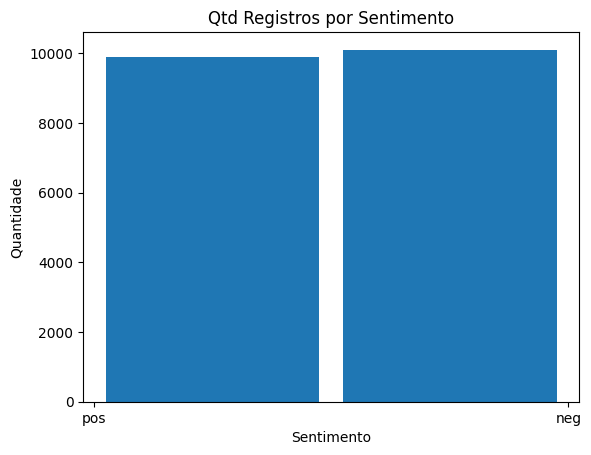

In [ ]:
# Histograma dos labels
plt.title('Qtd Registros por Sentimento')
plt.xlabel('Sentimento')
plt.ylabel('Quantidade')
plt.hist(imdb_data['sentiment'], 2, rwidth=0.9)
plt.show()

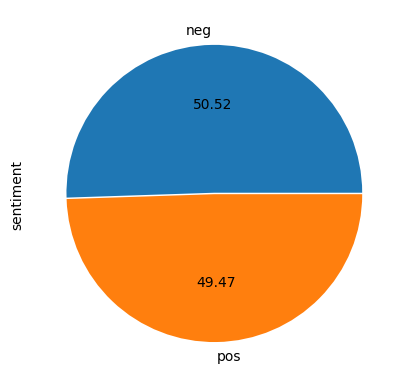

In [ ]:
# Gráfico de pizza para labels
imdb_data['sentiment'].value_counts().plot.pie(autopct='%.2f', explode=[0.01, 0]);

#### **Tratamento**

In [ ]:
# Cria instância do TokTokTokenizer
tokenizer=ToktokTokenizer()

# Gera lista de stopwords em Português
nltk.download('stopwords')
stopword_list=nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Configura stopwords para Português
stop=set(stopwords.words('portuguese'))

# Função para remover stopwords
def fn_rm_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [ ]:
imdb_data['texto_tratado']=imdb_data['text_pt'].apply(fn_rm_stopwords)

In [ ]:
# Função para remover caracteres especiais
def fn_rm_special_char(text, remove_digits=True):
    pattern = "[@!^&\/\\#,+()$~%.'\":*?<>{}\[\]0-9\_]"
    text=re.sub(pattern,'',text)
    return text

In [ ]:
# Aplica função de remover caracteres especiais
imdb_data['texto_tratado']=imdb_data['texto_tratado'].apply(fn_rm_special_char)

In [ ]:
# Baixa o algoritmo RSLP Stemmer (Removedor de Sufixos da Língua Portuguesa)
nltk.download('rslp')

# Função de stemming
def fn_stemmer(text):
    stemmer = RSLPStemmer()
    text= ' '.join([stemmer.stem(word) for word in text.split()])
    return text

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


In [ ]:
# Aplica função de stemming no texto
imdb_data['texto_tratado']=imdb_data['texto_tratado'].apply(fn_stemmer)

In [ ]:
imdb_data

,id,text_en,text_pt,sentiment,texto_tratado
12532,12534,This was unusual: a modern-day film which was ...,Isso era incomum: um filme moderno que era ult...,pos,incomum film modern ultra-leg verdad tão bom d...
35445,35447,Some of my old friends suggested me to watch t...,Alguns dos meus velhos amigos sugeriram que eu...,neg,algum velh amig suger assist film chanc recent...
20279,20281,What a pleasure. This is really a parody. Only...,Que prazer. Isto é realmente uma paródia. Some...,pos,praz real paród soment frances pod faz tip coi...
2969,2971,There are about ten minutes about half way thr...,"Há cerca de dez minutos a meio da Strangeland,...",neg,cerc dez minut mei strangeland repent vê vislu...
45161,45163,"Othello, the classic Shakespearen story of lov...","Otelo, a clássica história de Shakespearen sob...",pos,otel cláss histór shakespearen sobr am tra men...
...,...,...,...,...,...
27249,27251,When watching this show you are not quite sure...,Ao assistir a este show você não tem certeza s...,neg,assist show cert histór atu irrit prim tud enr...
42336,42338,If you still remember that summer when you had...,Se você ainda se lembra daquele verão em que v...,pos,aind lembr daquel ver prim beij prim garot nam...
24348,24350,I recommend that movie viewers if in the New Y...,"Eu recomendo que os espectadores do cinema, se...",pos,recom espect cinem áre cidad nov york visit mu...
41373,41375,"""Lion King 1 1/2"" is the funniest non-theatric...","""Lion King 1 1/2"" é o lançamento não teatral m...",pos,lion king lanç teatr engraç disney recent vi f...


##### Analisar Palavras

In [ ]:
from nltk.tokenize import RegexpTokenizer

# Método de quebra dos dados
tokenizer = RegexpTokenizer(r'\w+')

# Gerando listas de sentenças quebradas
imdb_data["tokens"] = imdb_data['texto_tratado'].apply(tokenizer.tokenize)

In [ ]:
tokens = [tuple(x) for x in imdb_data.tokens.values]

In [ ]:
def buscar_palavras(frases):
    todas_palavras = []
    for palavras in frases:
        todas_palavras.extend(palavras)
    return todas_palavras

In [ ]:
def buscar_frequencia(palavras):
    palavras = nltk.FreqDist(palavras)
    return palavras

In [ ]:
palavras = buscar_palavras(tokens)

In [ ]:
frequencia = buscar_frequencia(palavras)

In [ ]:
frequencia.most_common(15)

[('film', 77340),
 ('tod', 18200),
 ('pod', 17651),
 ('algum', 15103),
 ('real', 14655),
 ('faz', 14538),
 ('sobr', 11908),
 ('outr', 11596),
 ('histór', 11199),
 ('parec', 10511),
 ('person', 10300),
 ('vez', 10244),
 ('tão', 10022),
 ('melhor', 9704),
 ('apen', 9644)]

#### **Train/Test**

In [ ]:
train,test = train_test_split(imdb_data, test_size = 0.3, random_state=42)

In [ ]:
train_x, train_y = train['texto_tratado'], train['sentiment']
test_x, test_y = test['texto_tratado'], test['sentiment']

In [ ]:
print('Tamanho da base de Treinamento {}'.format(train.shape[0]))
print('Tamanho da base de Teste {}'.format(test.shape[0]))

Tamanho da base de Treinamento 14000
Tamanho da base de Teste 6000


In [ ]:
train_y.value_counts()

neg    7092
pos    6908
Name: sentiment, dtype: int64

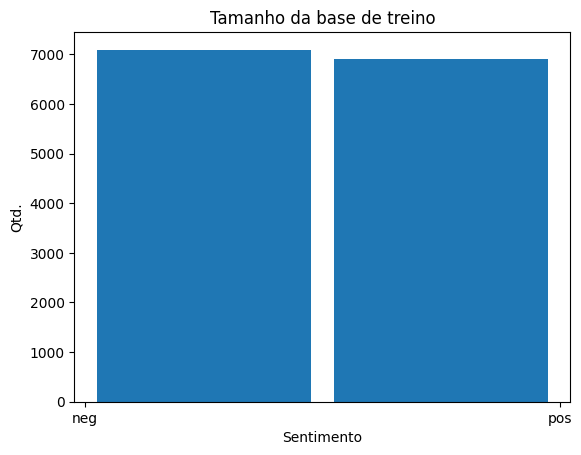

In [ ]:
# Histograma da base de treino
plt.title('Tamanho da base de treino')
plt.xlabel('Sentimento')
plt.ylabel('Qtd.')
plt.hist(train_y, 2, rwidth=0.9)
plt.show()

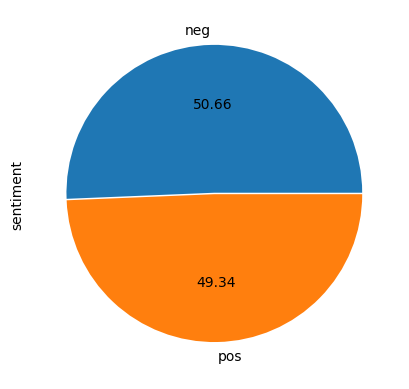

In [ ]:
# Proporção da base de Treino
train_y.value_counts().plot.pie(autopct='%.2f', explode=[0.01, 0]);

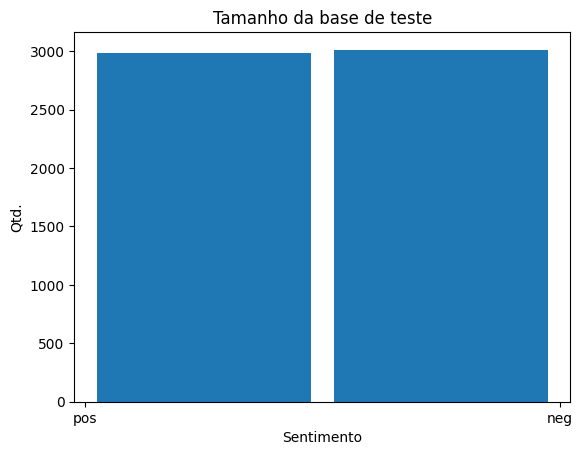

In [ ]:
# Histograma da base de teste
plt.title('Tamanho da base de teste')
plt.xlabel('Sentimento')
plt.ylabel('Qtd.')
plt.hist(test_y, 2, rwidth=0.9)
plt.show()

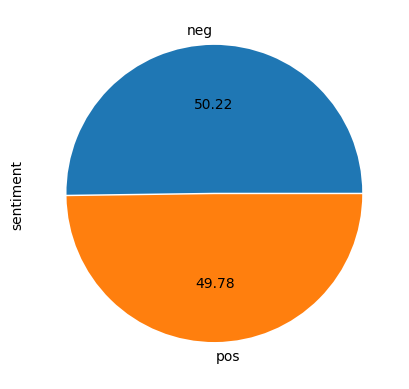

In [ ]:
# Proporção da base de Teste
test_y.value_counts().plot.pie(autopct='%.2f', explode=[0.01, 0]);

In [ ]:
test_y.value_counts()

neg    3013
pos    2987
Name: sentiment, dtype: int64

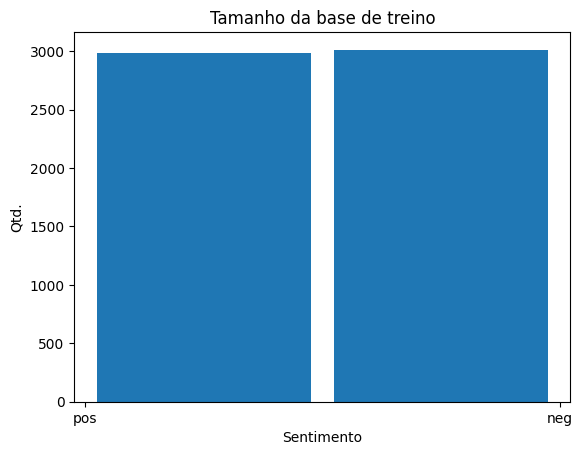

In [ ]:
# Histograma da base de treino
plt.title('Tamanho da base de treino')
plt.xlabel('Sentimento')
plt.ylabel('Qtd.')
plt.hist(test_y, 2, rwidth=0.9)
plt.show()

In [ ]:
tfidf = TfidfVectorizer()
train_x_vector = tfidf.fit_transform(train_x)
test_x_vector = tfidf.transform(test_x)
train_y_vector = tfidf.transform(train_y)
test_y_vector = tfidf.transform(test_y)

In [ ]:
pd.DataFrame.sparse.from_spmatrix(train_x_vector,
                                  index=train_x.index,
                                  columns=tfidf.get_feature_names_out())

,aa,aaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaargh,aaaahhhhhh,aaahhhhhhh,aaargh,aaarrrgh,aaaugh,aaawwwwnnn,...,únicoelevis,únicoum,útel,úter,útil,über,übermensch,überwoman,œaberr,ʻo
31868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
with open('/content/drive/MyDrive/Pos_PucMinas_2021/TCC/Modelos/tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf, file)

## **MODELOS**

### **Decision Trees**

In [ ]:
%%time
dec_tree = DecisionTreeClassifier()
dec_tree.fit(train_x_vector, train_y)

CPU times: user 18.2 s, sys: 39 ms, total: 18.2 s
Wall time: 18.6 s


DecisionTreeClassifier()

In [ ]:
print(dec_tree.predict(tfidf.transform(['Hoje está um dia lindo'])))
print(dec_tree.predict(tfidf.transform(['O dia de hoje vai ser muito produtivo'])))
print(dec_tree.predict(tfidf.transform(['Não estou animado para esse show'])))
print(dec_tree.predict(tfidf.transform(['Leite vegetal não é bom'])))

['pos']
['pos']
['pos']
['pos']


In [ ]:
# Predições com a base de teste
y_pred_dec_tree = dec_tree.predict(test_x_vector)

In [ ]:
# Acurácia e F1 Score
accuracy_dec_tree = accuracy_score(test_y, y_pred_dec_tree)
f1_score_dec_tree = f1_score(test_y,y_pred_dec_tree,
          labels = ['pos','neg'],average=None)

# Precisão e Recall
tn, fp, fn, tp = confusion_matrix(test_y, y_pred_dec_tree).ravel()
precision_score_dec_tree = tp / (tp + fp)
recall_score_dec_tree = tp / (tp + fn)

In [ ]:
# Métricas
print("Accuracy Decision Trees:", accuracy_dec_tree)
print("F1 Score Decision Trees: pos {} neg {}".format(f1_score_dec_tree[0],f1_score_dec_tree[1]) )
print("Precision Decision Trees:", precision_score_dec_tree)
print("Recall Decision Trees:", recall_score_dec_tree)

Accuracy Decision Trees: 0.6831666666666667
F1 Score Decision Trees: pos 0.6763153413928146 neg 0.6897339644197813
Precision Decision Trees: 0.6881496881496881
Recall Decision Trees: 0.6648811516571811


### **Logistic Regression**

In [ ]:
%%time
lr = LogisticRegression(penalty='l2',max_iter=500,C=10,random_state=42)
lr.fit(train_x_vector,train_y)

CPU times: user 2.73 s, sys: 2.32 s, total: 5.06 s
Wall time: 5.78 s


LogisticRegression(C=10, max_iter=500, random_state=42)

In [ ]:
print(lr.predict(tfidf.transform(['Hoje está um dia lindo'])))
print(lr.predict(tfidf.transform(['O dia de hoje vai ser muito produtivo'])))
print(lr.predict(tfidf.transform(['Não estou animado para esse show'])))
print(lr.predict(tfidf.transform(['Leite vegetal não é bom'])))

['neg']
['pos']
['neg']
['neg']


In [ ]:
# Pedições com base de teste
y_pred_lr = lr.predict(test_x_vector)

In [ ]:
# Acurácia e F1 Score
accuracy_lr = accuracy_score(test_y, y_pred_lr)
f1_score_lr = f1_score(test_y,y_pred_lr,
          labels = ['pos','neg'],average=None)

# Precisão e Recall
tn, fp, fn, tp = confusion_matrix(test_y, y_pred_lr).ravel()
precision_score_lr = tp / (tp + fp)
recall_score_lr = tp / (tp + fn)

In [ ]:
# Métricas
print("Accuracy Logistic Regression:", accuracy_lr)
print("F1 Score Logistic Regression: pos {} neg {}".format(f1_score_lr[0],f1_score_lr[1]) )
print("Precision Logistic Regression:", precision_score_lr)
print("Recall Logistic Regression:", recall_score_lr)

Accuracy Logistic Regression: 0.8643333333333333
F1 Score Logistic Regression: pos 0.8636515912897824 neg 0.8650082918739634
Precision Logistic Regression: 0.8642306402950051
Recall Logistic Regression: 0.863073317710077


### **Naive Bayes**

In [ ]:
%%time
gnb = GaussianNB()
gnb.fit(train_x_vector.toarray(), train_y)

CPU times: user 7.91 s, sys: 13.7 s, total: 21.6 s
Wall time: 22.3 s


GaussianNB()

In [ ]:
print(gnb.predict(tfidf.transform(['Hoje está um dia lindo']).toarray()))
print(gnb.predict(tfidf.transform(['O dia de hoje vai ser muito produtivo']).toarray()))
print(gnb.predict(tfidf.transform(['Não estou animado para esse show']).toarray()))
print(gnb.predict(tfidf.transform(['Leite vegetal não é bom']).toarray()))

['pos']
['pos']
['neg']
['neg']


In [ ]:
# Predição na base de teste
y_pred_gnb = gnb.predict(test_x_vector.toarray())

In [ ]:
# Acurácia e F1 Score
accuracy_gnb = accuracy_score(test_y, y_pred_gnb)
f1_score_gnb = f1_score(test_y,y_pred_gnb,
          labels = ['pos','neg'],average=None)

# Precisão e Recall
tn, fp, fn, tp = confusion_matrix(test_y, y_pred_gnb).ravel()
precision_score_gnb = tp / (tp + fp)
recall_score_gnb = tp / (tp + fn)

In [ ]:
print("Accuracy Naive Bayes:", accuracy_gnb)
print("F1 Score Naive Bayes: pos {} neg {}".format(f1_score_gnb[0],f1_score_gnb[1]) )
print("Precision Naive Bayes:", precision_score_gnb)
print("Recall Naive Bayes:", recall_score_gnb)

Accuracy Naive Bayes: 0.6358333333333334
F1 Score Naive Bayes: pos 0.5868784269238042 neg 0.6744151393234988
Precision Naive Bayes: 0.6741963509991312
Recall Naive Bayes: 0.5195848677602946


### **Support Vector Machine (SVM)**

In [ ]:
%%time
svc = SVC(kernel='linear',probability=True)
svc.fit(train_x_vector, train_y)

CPU times: user 11min 53s, sys: 1.53 s, total: 11min 55s
Wall time: 12min 18s


SVC(kernel='linear', probability=True)

In [ ]:
print(svc.predict(tfidf.transform(['Hoje está um dia lindo'])))
print(svc.predict(tfidf.transform(['O dia de hoje vai ser muito produtivo'])))
print(svc.predict(tfidf.transform(['Não estou animado para esse show'])))
print(svc.predict(tfidf.transform(['Leite vegetal não é bom'])))

['neg']
['pos']
['neg']
['neg']


In [ ]:
# Predições com a base de teste
y_pred_svc = svc.predict(test_x_vector)

In [ ]:
# Acurácia e F1 Score
accuracy_svc = accuracy_score(test_y, y_pred_svc)
f1_score_svc = f1_score(test_y,y_pred_svc,
          labels = ['pos','neg'],average=None)

# Precisão e Recall
tn, fp, fn, tp = confusion_matrix(test_y, y_pred_svc).ravel()
precision_score_svc = tp / (tp + fp)
recall_score_svc = tp / (tp + fn)

In [ ]:
print("Accuracy SVC:", accuracy_svc)
print("F1 Score SVC: pos {} neg {}".format(f1_score_svc[0],f1_score_svc[1]) )
print("Precision SVC:", precision_score_svc)
print("Recall SVC:", recall_score_svc)

Accuracy SVC: 0.8675
F1 Score SVC: pos 0.8666778467214489 neg 0.8683120755342058
Precision SVC: 0.8682795698924731
Recall SVC: 0.8650820220957482


### **Random Forest**

In [ ]:
ESTIMATOR = 200

In [ ]:
%%time
rf = RandomForestClassifier(n_estimators=ESTIMATOR, random_state=0)
rf.fit(train_x_vector, train_y)

CPU times: user 1min 5s, sys: 165 ms, total: 1min 6s
Wall time: 1min 7s


RandomForestClassifier(n_estimators=200, random_state=0)

In [ ]:
print(rf.predict(tfidf.transform(['Hoje está um dia lindo'])))
print(rf.predict(tfidf.transform(['O dia de hoje vai ser muito produtivo'])))
print(rf.predict(tfidf.transform(['Não estou animado para esse show'])))
print(rf.predict(tfidf.transform(['Leite vegetal não é bom'])))

['pos']
['pos']
['pos']
['pos']


In [ ]:
# Predições com a base de teste
y_pred_rf = rf.predict(test_x_vector)

In [ ]:
# Acurácia e F1 Score
accuracy_rf = accuracy_score(test_y, y_pred_rf)
f1_score_rf = f1_score(test_y,y_pred_rf,
          labels = ['pos','neg'],average=None)

# Precisão e Recall
tn, fp, fn, tp = confusion_matrix(test_y, y_pred_rf).ravel()
precision_score_rf = tp / (tp + fp)
recall_score_rf = tp / (tp + fn)

In [ ]:
print("Accuracy Random Forest:", accuracy_rf)
print("F1 Score Random Forest: pos {} neg {}".format(f1_score_rf[0],f1_score_rf[1]) )
print("Precision Random Forest:", precision_score_rf)
print("Recall Random Forest:", recall_score_rf)

Accuracy Random Forest: 0.8331666666666667
F1 Score Random Forest: pos 0.8269662921348314 neg 0.8389380530973451
Precision Random Forest: 0.8548963545389564
Recall Random Forest: 0.8008034817542685



## **DESEMPENHO MODELOS**

### **Métricas**

In [ ]:
# Acurácia
print("Accuracy Decision Trees", dec_tree.score(test_x_vector, test_y))
print("Accuracy Logistic Regression:", lr.score(test_x_vector, test_y))
print("Accuracy Naive Bayes:", gnb.score(test_x_vector.toarray(), test_y))
print("Accuracy Random Forest:", accuracy_rf)
print("Accuracy SVC:", svc.score(test_x_vector, test_y))

Accuracy Decision Trees 0.6831666666666667
Accuracy Logistic Regression: 0.8643333333333333
Accuracy Naive Bayes: 0.6358333333333334
Accuracy Random Forest: 0.8331666666666667
Accuracy SVC: 0.8675


In [ ]:
# F1 Score
print("F1 Score Decision Trees: pos {} neg {}".format(f1_score_dec_tree[0],f1_score_dec_tree[1]) )
print("F1 Score Logistic Regression: pos {} neg {}".format(f1_score_lr[0],f1_score_lr[1]) )
print("F1 Score Naive Bayes: pos {} neg {}".format(f1_score_gnb[0],f1_score_gnb[1]) )
print("F1 Score Random Forest: pos {} neg {}".format(f1_score_rf[0],f1_score_rf[1]) )
print("F1 Score SVC: pos {} neg {}".format(f1_score_svc[0],f1_score_svc[1]) )

F1 Score Decision Trees: pos 0.6763153413928146 neg 0.6897339644197813
F1 Score Logistic Regression: pos 0.8636515912897824 neg 0.8650082918739634
F1 Score Naive Bayes: pos 0.5868784269238042 neg 0.6744151393234988
F1 Score Random Forest: pos 0.8269662921348314 neg 0.8389380530973451
F1 Score SVC: pos 0.8666778467214489 neg 0.8683120755342058


In [ ]:
# Precisão
print("Precision Decision Trees:", precision_score_dec_tree)
print("Precision Logistic Regression:", precision_score_lr)
print("Precision Naive Bayes:", precision_score_gnb)
print("Precision Random Forest:", precision_score_rf)
print("Precision SVC:", precision_score_svc)

Precision Decision Trees: 0.6881496881496881
Precision Logistic Regression: 0.8642306402950051
Precision Naive Bayes: 0.6741963509991312
Precision Random Forest: 0.8548963545389564
Precision SVC: 0.8682795698924731


In [ ]:
# Recall
print("Recall Decision Trees:", recall_score_dec_tree)
print("Recall Logistic Regression:", recall_score_lr)
print("Recall Naive Bayes:", recall_score_gnb)
print("Recall Random Forest:", recall_score_rf)
print("Recall SVC:", recall_score_svc)

Recall Decision Trees: 0.6648811516571811
Recall Logistic Regression: 0.863073317710077
Recall Naive Bayes: 0.5195848677602946
Recall Random Forest: 0.8008034817542685
Recall SVC: 0.8650820220957482


### **Classification Report**

In [ ]:
print(classification_report(test_y,
                            dec_tree.predict(test_x_vector),
                            labels = ['pos','neg']))

              precision    recall  f1-score   support

         pos       0.69      0.66      0.68      2987
         neg       0.68      0.70      0.69      3013

    accuracy                           0.68      6000
   macro avg       0.68      0.68      0.68      6000
weighted avg       0.68      0.68      0.68      6000



In [ ]:
print(classification_report(test_y,
                            lr.predict(test_x_vector),
                            labels = ['pos','neg']))

              precision    recall  f1-score   support

         pos       0.86      0.86      0.86      2987
         neg       0.86      0.87      0.87      3013

    accuracy                           0.86      6000
   macro avg       0.86      0.86      0.86      6000
weighted avg       0.86      0.86      0.86      6000



In [ ]:
print(classification_report(test_y,
                            gnb.predict(test_x_vector.toarray()),
                            labels = ['pos','neg']))

              precision    recall  f1-score   support

         pos       0.67      0.52      0.59      2987
         neg       0.61      0.75      0.67      3013

    accuracy                           0.64      6000
   macro avg       0.64      0.64      0.63      6000
weighted avg       0.64      0.64      0.63      6000



In [ ]:
print(classification_report(test_y,
                            svc.predict(test_x_vector),
                            labels = ['pos','neg']))

              precision    recall  f1-score   support

         pos       0.87      0.87      0.87      2987
         neg       0.87      0.87      0.87      3013

    accuracy                           0.87      6000
   macro avg       0.87      0.87      0.87      6000
weighted avg       0.87      0.87      0.87      6000



In [ ]:
print(classification_report(test_y,
                            rf.predict(test_x_vector),
                            labels = ['pos','neg']))

              precision    recall  f1-score   support

         pos       0.85      0.80      0.83      2987
         neg       0.81      0.87      0.84      3013

    accuracy                           0.83      6000
   macro avg       0.83      0.83      0.83      6000
weighted avg       0.83      0.83      0.83      6000



### **Confusion Matrix**

In [ ]:
conf_mat_dec_tree = confusion_matrix(test_y,
                           dec_tree.predict(test_x_vector),
                           labels = ['pos', 'neg'])
#conf_mat_dec_tree

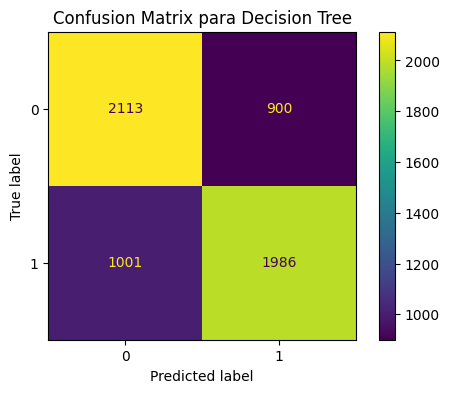

In [ ]:
fig, ax = plt.subplots(figsize=(6,4), dpi=100)
cm = confusion_matrix(test_y, y_pred_dec_tree)
ax.set(title='Confusion Matrix para Decision Tree')
cm_display_dec_tree = ConfusionMatrixDisplay(cm).plot(ax=ax)

In [ ]:
conf_mat_lr = confusion_matrix(test_y,
                           lr.predict(test_x_vector),
                           labels = ['pos', 'neg'])
conf_mat_lr

array([[2578,  409],
       [ 405, 2608]])

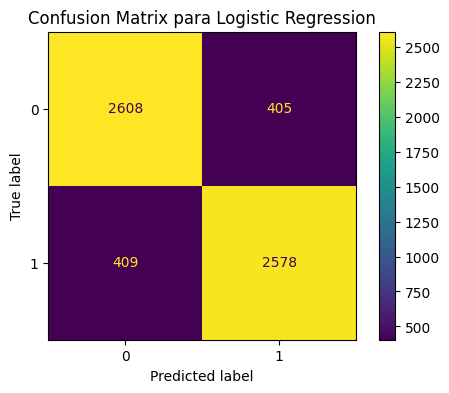

In [ ]:
fig, ax = plt.subplots(figsize=(6,4), dpi=100)
cm = confusion_matrix(test_y, y_pred_lr)
ax.set(title='Confusion Matrix para Logistic Regression')
cm_display_lr = ConfusionMatrixDisplay(cm).plot(ax=ax)

In [ ]:
conf_mat_gnb = confusion_matrix(test_y,
                           gnb.predict(test_x_vector.toarray()),
                           labels = ['pos', 'neg'])
conf_mat_gnb

array([[1552, 1435],
       [ 750, 2263]])

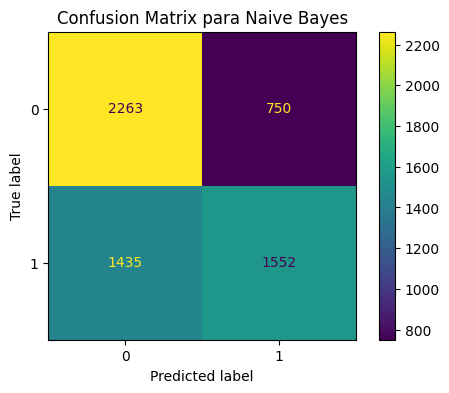

In [ ]:
fig, ax = plt.subplots(figsize=(6,4), dpi=100)
cm = confusion_matrix(test_y, y_pred_gnb)
ax.set(title='Confusion Matrix para Naive Bayes')
cm_display_gnb = ConfusionMatrixDisplay(cm).plot(ax=ax)

In [ ]:
conf_mat_svc = confusion_matrix(test_y,
                           svc.predict(test_x_vector),
                           labels = ['pos', 'neg'])
conf_mat_svc

array([[2584,  403],
       [ 392, 2621]])

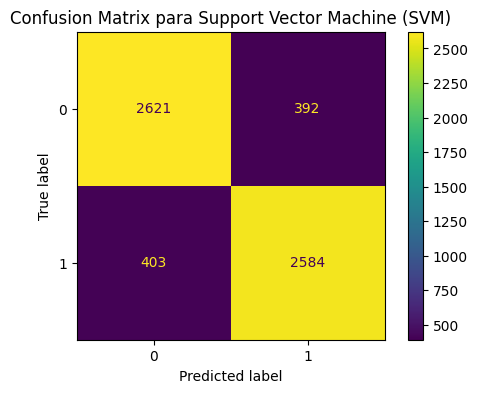

In [ ]:
fig, ax = plt.subplots(figsize=(6,4), dpi=100)
cm = confusion_matrix(test_y, y_pred_svc)
ax.set(title='Confusion Matrix para Support Vector Machine (SVM)')
cm_display_svc = ConfusionMatrixDisplay(cm).plot(ax=ax)

In [ ]:
conf_mat_rf = confusion_matrix(test_y,
                           rf.predict(test_x_vector),
                           labels = ['pos', 'neg'])
conf_mat_rf

array([[2392,  595],
       [ 406, 2607]])

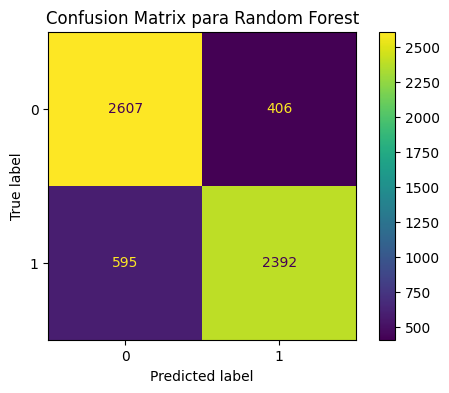

In [ ]:
fig, ax = plt.subplots(figsize=(6,4), dpi=100)
cm = confusion_matrix(test_y, y_pred_rf)
ax.set(title='Confusion Matrix para Random Forest')
cm_display_rf = ConfusionMatrixDisplay(cm).plot(ax=ax)

## **RESULTADOS**

Tomando por base as métricas Acurácia e F1 Score, o melhor modelo para a situação proposta é o SVC.

### Exportar o arquivo do modelo

In [ ]:
with open('/content/drive/MyDrive/Pos_PucMinas_2021/TCC/Modelos/svc_model.pkl', 'wb') as file:
    pickle.dump(svc, file)